## Solution to Assignment 4 (Approach 1)

### Data Preparation

In [ ]:
from sklearn import datasets
import numpy as np

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2]  # We only take the first two features, sepal length and width
y = iris.target

# The dataset is now loaded into X and y


In [ ]:
# Example for one species
species_idx = 0  # You can change to 1 and 2 for the other species
y_binary = (y == species_idx).astype(np.float64)
y_binary *=10

y_binary[y_binary==0]=-10

In [ ]:
y_binary

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10.])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

### One vs Rest Classification

In [ ]:
with pm.Model() as model:
  # Priors for the GP hyperparameters
  ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
  η = pm.HalfCauchy("η", beta=5)

  # Covariance function
  cov = η**2 * pm.gp.cov.ExpQuad(2, ℓ)  # 2 input dimensions

  # GP
  #gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")
  gp = pm.gp.Marginal(cov_func=cov)

  # Noise term
  σ = pm.HalfNormal("σ", sigma=1)

  # GP marginal likelihood
  y_ = gp.marginal_likelihood("y_", X=X, y=y_binary, sigma=σ)

  # Sampling
  trace = pm.sample(1000, tune=1000, return_inferencedata=True)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'ℓ'}>, <Axes: title={'center': 'ℓ'}>],
       [<Axes: title={'center': 'η'}>, <Axes: title={'center': 'η'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

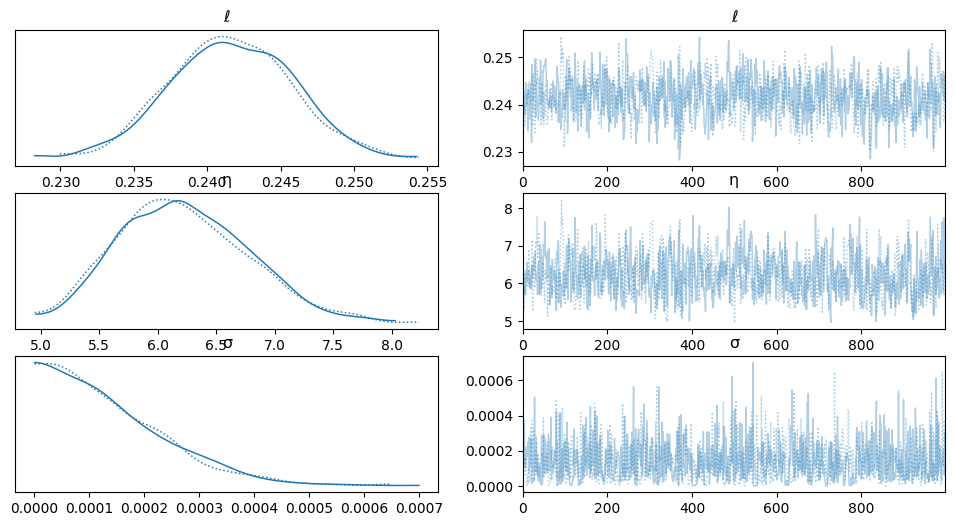

In [ ]:
# Example for one species
species_idx = 0  # Change to 1 and 2 for the other species
y_binary = (y == species_idx).astype(np.float64)

# Use arviz to visualize the posterior and model performance
az.plot_trace(trace)

### Generate a grid of points and making predictions

In [ ]:
# Step 1: Generate a grid of points
sepal_length_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
sepal_width_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
xx, yy = np.meshgrid(sepal_length_range, sepal_width_range)
grid = np.vstack((xx.flatten(), yy.flatten())).T

#print(grid)

print(np.shape(grid))
print(np.shape(xx))
print(np.shape(yy))

(400, 2)
(20, 20)
(20, 20)


In [ ]:
# Step 2: Predict using the model
# Note: Replace 'model' and 'trace' with the actual variables from your model training
with model:
    # Create a GP conditional for the grid points
    f_pred_2 = gp.conditional('f_pred_2', grid)
    # Sample from the posterior predictive distribution
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred_2"])


In [ ]:
np.shape(pred_samples.posterior_predictive['f_pred_2'].values.mean(axis=0).mean(axis=0))

tmp_y = pred_samples.posterior_predictive['f_pred_2'].values.mean(axis=0).mean(axis=0)

In [ ]:
# Use "link function" like the sigmoid to map latent values to probabilities.
# The scale of the latent values can significantly affect the interpretation of the probabilities obtained after applying the sigmoid function.

def sigmoid(x, scaling=1):
    return 1 / (1 + np.exp(-scaling*x))

In [ ]:
max(tmp_y)

11.072002469534395

In [ ]:
probs_grid = sigmoid(tmp_y)

print(np.shape(probs_grid), np.shape(xx), np.shape(yy))

(400,) (20, 20) (20, 20)


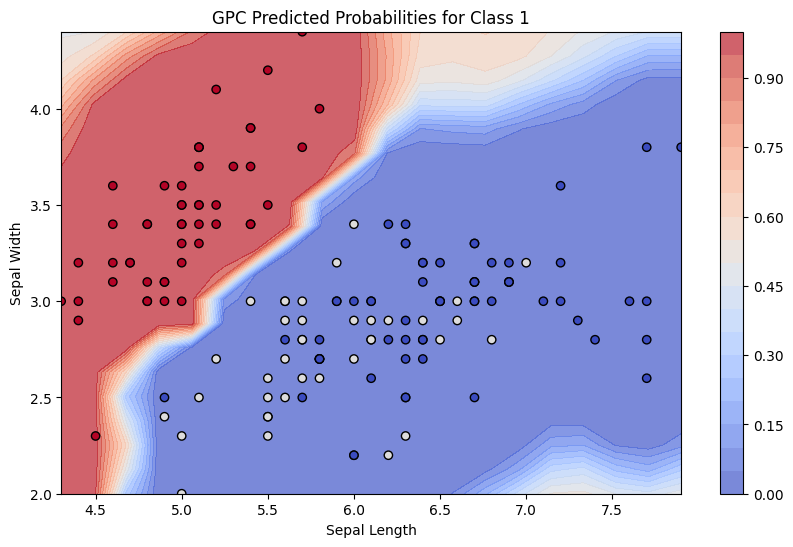

In [ ]:
# The predictions are probabilities after applying the logistic function
#probs = pm.math.invlogit(tmp_probs)

# Step 3: Visualize the predictions
# Reshape the probabilities back to the grid shape for plotting
probs_grid = probs_grid.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
levels = np.linspace(0,1,21)
contour = plt.contourf(xx, yy, probs_grid, 50, cmap="coolwarm", alpha=0.7, levels=levels)
plt.colorbar(contour, extend='both')
plt.scatter(X[:,0], X[:,1], c=-y, cmap="coolwarm", edgecolors="k")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("GPC Predicted Probabilities for Class 1")
plt.show()

In [ ]:
np.shape(pred_samples.posterior_predictive['f_pred_2'])

(2, 1000, 400)

In [ ]:
# Assuming `pred_samples` contains samples of predictions from the posterior predictive
# Let's calculate the standard deviation (as a measure of uncertainty) for each point
# on the grid.

tmp_stdev = np.std(sigmoid(pred_samples.posterior_predictive['f_pred_2'].mean(axis=0)),axis=0).values


(400,) <class 'numpy.ndarray'>
(400,) <class 'numpy.ndarray'>


In [ ]:
print(tmp_stdev[0 : 10])

[2.87565601e-01 2.69386882e-01 3.84454639e-01 1.08073390e-02
 7.68272100e-05 2.53189744e-02 1.09563335e-02 8.80328691e-03
 4.84495415e-02 5.92677156e-02]


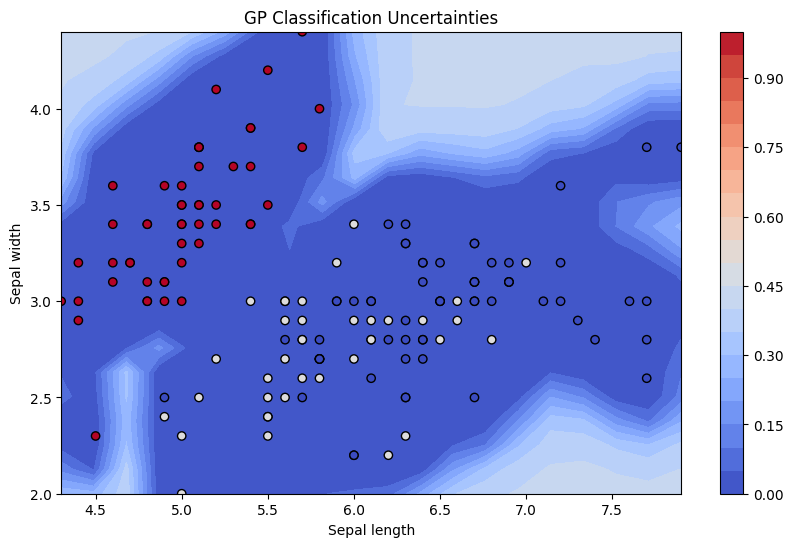

In [ ]:
# The standard deviation is reshaped to fit the grid for contour plotting
std_dev_reshaped = tmp_stdev.reshape(xx.shape)

# Now, let's plot the uncertainties
plt.figure(figsize=(10, 6))
contour = plt.contourf(xx, yy, std_dev_reshaped, 25, cmap='coolwarm', levels=levels)
plt.colorbar(contour)
plt.scatter(X[:, 0], X[:, 1], c=-y, cmap='coolwarm', edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('GP Classification Uncertainties')
plt.show()


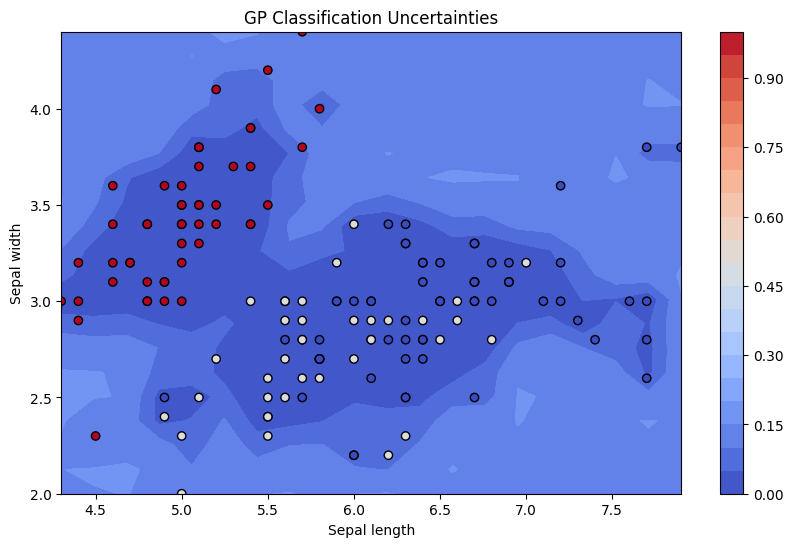

In [ ]:
# The standard deviation is reshaped to fit the grid for contour plotting
std_dev_reshaped_v2 = tmp_stdev_v2.reshape(xx.shape)

# Now, let's plot the uncertainties
plt.figure(figsize=(10, 6))
contour = plt.contourf(xx, yy, std_dev_reshaped_v2, 25, cmap='coolwarm', levels=levels)
plt.colorbar(contour)
plt.scatter(X[:, 0], X[:, 1], c=-y, cmap='coolwarm', edgecolors='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('GP Classification Uncertainties')
plt.show()
